## 共有ドライブのマウント
- 参考：https://qiita.com/kikuchi_kentaro/items/65be0cf40ac61849d841

In [2]:
infile_name = "20190911_8genre_288video_text"

!pip install japanize_matplotlib
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# URLを開いて認証コードをコピーしボックスに貼り付けしてください
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!cp -f ~/.gdfuse/default/config config
!sed -i -e "s/^root_folder=$/root_folder=1Dm6GSlI06zTsmRg6KdpM2WBYU0wj-Umh/" config

!mkdir -p drive
!google-drive-ocamlfuse -config ./config -cc drive
!ls drive

     |████████████████████████████████| 4.1MB 4.8MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.0.5-cp36-none-any.whl size=4118721 sha256=b3f0aa269b68cfc04f499a07ae76bad1f65e7e132f4e56972dc9253ca61df0d4
  Stored in directory: /root/.cache/pip/wheels/6c/8a/08/4a784957da9f3c2b4839b4986be2fba2a481877318948be52c
Successfully built japanize-matplotlib
E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 132684 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.13-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleuserc

In [3]:
import os
import csv
import pickle

import numpy as np
import pandas as pd

import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
sns.set(font='IPAexGothic')

from IPython.display import display, Image
import warnings
warnings.filterwarnings('ignore')
os.chdir("drive")
!ls

config	drive  dust  input  memo  midway  model  notebook  output


-----------

## CSVファイルのインポート

前回作成した'words','labels'csvファイルを読み込んでリストとして扱います。

In [0]:
#csvファイルをインポートして'labels'リストに格納
f = open(f"midway/{infile_name}_labels.csv", "r")
reader = csv.reader(f)
labels = [e for e in reader]
f.close()

words = np.load(f"midway/{infile_name}_words_lemmatized_without_stop_words.npz", allow_pickle=True)
# words = np.load(f"midway/{infile_name}_words_lemmatized.npz", allow_pickle=True)

from itertools import chain
import collections
#'labels'リストの入れ子構造を解除
labels = list(chain.from_iterable(labels))
#'labels'リストをstr型からint型に変換
labels = [int(s) for s in labels]

n_samples = len(words["名詞"])

In [0]:
import sys
sys.path.append('/content/drive/notebook/NLP')
import vectorizer

## NLP class

In [0]:
import gensim
word_vecs = gensim.models.KeyedVectors.load_word2vec_format('model/model_fasttext_neo.vec', binary = False)

In [0]:
import re
import time
from sklearn import mixture
from sklearn.model_selection import train_test_split

class Vectorizer:
  word_vecs = None
  def __init__(self, word_vecs, random_state=0):
    Vectorizer.word_vecs = word_vecs
    self.random_state = random_state
    self.word_vec_dim = 300
    self.dr_ = None

  def fit(self, X, y=None):
    return self

  def add_feature(self, X):
    self.add_letter_len(X)
    self.add_used_rate(X)
    self.add_letter_kinds(X)

  def add_letter_len(self, X):
    word_len = []
    for i, doc in enumerate(X):
      cnt = 0
      for w in doc:
        cnt += len(w)
      word_len.append(cnt/len(doc))
    word_len = np.array(word_len).reshape(-1, 1)
    self.dr_ = np.hstack([self.dr_, word_len])

  def add_used_rate(self, X):
    used_rate = []
    corpus = set(Vectorizer.word_vecs.index2word)
    for i, doc in enumerate(X):
      cnt = 0
      for w in doc:
        if w in corpus:
          cnt += 1
      used_rate.append(cnt/len(doc))
    used_rate = np.array(used_rate).reshape(-1, 1)
    self.dr_ = np.hstack([self.dr_, used_rate])

  def add_letter_kinds(self, X):
    char_rate = []
    hira = re.compile('[ぁ-ゟ]+')
    digit = re.compile('[0-9]+')
    kanji = re.compile('[\u2E80-\u2FDF\u3005-\u3007\u3400-\u4DBF\u4E00-\u9FFF\uF900-\uFAFF\U00020000-\U0002EBEF]+')
    for doc in X:
      num_hira = 0
      num_digit = 0
      num_kanji = 0
      for w in doc:
        num_hira += int(hira.search(w)!=None)
        num_digit += int(digit.search(w)!=None)
        num_kanji += int(kanji.fullmatch(w)!=None)
      char_rate.append([num_hira/len(doc), num_digit/len(doc), num_kanji/len(doc)])    
    self.dr_ = np.hstack([self.dr_, np.array(char_rate)])

class SCDV(Vectorizer):
  def __init__(self, word_vecs, n_components=3, random_state=0):
    super().__init__(word_vecs, random_state)
    self.n_components = n_components

  def transform(self, X):
    self.n_samples = len(X)

    def idf(word):
      df = np.sum(np.array([int(word in d) for d in X], dtype="float32"))
      return np.log((self.n_samples+1) / (df+1.0)) + 1

    ex_words = set(Vectorizer.word_vecs.index2word)
    used_words = set([w for doc in X for w in doc])
    self.ex_used_words = list(ex_words & used_words)

    used_word_vectors = np.array([Vectorizer.word_vecs[w] for w in self.ex_used_words])
    gmm = mixture.GaussianMixture(n_components=self.n_components, covariance_type='tied', max_iter=50, random_state=self.random_state)
    gmm.fit(used_word_vectors)
    word_probs = gmm.predict_proba(used_word_vectors)

    word_cluster_vectors = np.zeros(shape=(len(self.ex_used_words), self.n_components*self.word_vec_dim))
    for i, used_word in enumerate(self.ex_used_words):
      tmp = np.array([])
      for j in range(self.n_components):
        tmp = np.hstack([tmp, idf(used_word)*word_probs[i][j]*Vectorizer.word_vecs[used_word]])
      word_cluster_vectors[i] = tmp
    self.dr_ = np.zeros(shape=(self.n_samples, self.n_components*self.word_vec_dim))
    cnts = np.zeros(self.n_samples)
    for i, doc in enumerate(X):
      for w in doc:
        if not w in self.ex_used_words:
          continue
        self.dr_[i] += word_cluster_vectors[self.ex_used_words.index(w)]
        cnts[i] += 1
    for i in range(self.n_components):
      if np.linalg.norm(self.dr_[i])==0:
        continue
      # doc_vectors[i] = doc_vectors[i]/np.linalg.norm(doc_vectors[i])
      self.dr_[i] /= cnts[i]
    self.add_feature(X)
    return self.dr_

class SWEM(Vectorizer):
  def __init__(self, word_vecs, random_state=0):
    super().__init__(word_vecs, random_state)

  def transform(self, X):
    ex_words = set(Vectorizer.word_vecs.index2word)
    used_words = set([w for doc in X for w in doc])
    self.ex_used_words = list(ex_words & used_words)
    self.dr_ = np.zeros((len(X), self.word_vec_dim))
    for i, doc in enumerate(X):
        self.dr_[i, :] = self.get_doc_swem_max_vector(doc)
    self.add_feature(X)
    return self.dr_

  def get_doc_swem_max_vector(self, doc):
    # https://nbviewer.jupyter.org/github/nekoumei/Comparison-DocClassification/blob/master/src/Classification_News.ipynb
      word_cnt = 0
      doc_vector = np.zeros((len(doc), self.word_vec_dim))
      for i, word in enumerate(doc):
          try:
              wv = Vectorizer.word_vecs.wv[word]
          except KeyError:
              wv = np.zeros(self.word_vec_dim)
          doc_vector[i, :] = wv
      doc_vector = np.max(doc_vector, axis=0)
      return doc_vector


In [0]:
# 意味的に類似した分散表現となるはずが、0.89 rad = 51度 離れている
v1 = word_vecs['Actor']
v2 = word_vecs['actor']

np.arccos(np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))*(180/np.pi)

51.398601013882484

In [0]:
v1 = word_vecs['banana']
v2 = word_vecs['actor']

np.linalg.norm(v1-v2)

5.5346947

In [0]:
v1 = word_vecs['banana']
v2 = word_vecs['apple']

np.linalg.norm(v1-v2)

5.3735056

In [0]:
# 意味的に類似した分散表現となるはずが、0.89 rad = 51度 離れている
v1 = word_vecs['dog']
v2 = word_vecs['Dog']

np.arccos(np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))*(180/np.pi)

55.48851145869695

In [0]:
from sklearn.pipeline import Pipeline
!pip install lightgbm
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA, TruncatedSVD, FactorAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering

In [0]:
words_selected = []
ps_selected = [
# FIXME: 全て空配列が入っているのでdtype=float, shape=(n_samples, 1)となって配列の連結時にエラーが出ます
              # 'その他', 
              'フィラー', 
              '副詞', 
              '助動詞', 
              '助詞', 
              '動詞', 
              '名詞', 
              '形容詞', 
              '感動詞', 
              '接続詞', 
              '接頭詞', 
              '記号', 
              '連体詞'
            ]

for i in range(n_samples):
  words_ps = []
  for ps in ps_selected:
    words_ps += words[ps][i]
  words_selected.append(words_ps)

quantify = Pipeline([
                 ("swem", SWEM(word_vecs, random_state=0)),
                 ("decomp", FactorAnalysis(30))
])

trimmed_words = [[re.sub('[0-9]+',"", w) for w in doc if not w.isdigit()] for doc in words_selected]

In [0]:
# supervised learning
supervised = Pipeline([
                 ("quantify", quantify),
                 ("LGBM", lgb.LGBMClassifier(random_state=0, n_estimators=100))
])

cross_val_score(supervised, trimmed_words, labels, cv=5).mean()
# supervised.fit(X_train, y_train).score(X_test, y_test)

0.5528362442155546

In [0]:
num_cluster = 20
unsupervised = Pipeline([
                    ("quantify", quantify),
                    # ("clustering", KMeans(num_cluster))
                    ("clustering", AgglomerativeClustering(num_cluster))
])

# clustering = DBSCAN(eps=3, min_samples=2)
clustering = AgglomerativeClustering(num_cluster)
pred = clustering.fit_predict(quantify.fit_transform(trimmed_words))
manual_labels = np.array(labels)

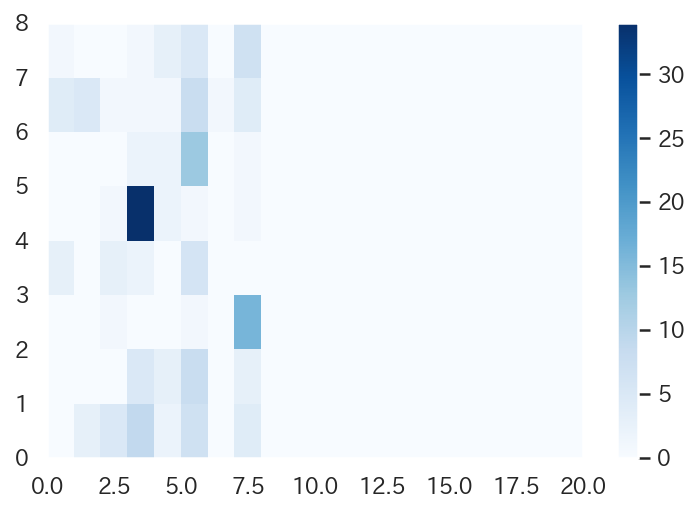

In [0]:
match_map = np.zeros((8, num_cluster))
for i in range(8):
  for j in range(num_cluster):
    match_map[i][j] = np.dot((pred==i).astype(int), manual_labels==j)
plt.pcolor(match_map, cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

In [0]:
np.bincount(pred)

array([30, 19, 18, 14, 39, 18, 25, 17,  2, 18,  3,  1, 50, 10,  1,  1,  3,
       12,  4,  2])